<a href="https://colab.research.google.com/github/lagom-QB/M12/blob/master/Day%2004%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Name Generation (RNN)

In [2]:
# ---------- Import things

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from IPython.display import clear_output
from random import sample

In [3]:
start_token = " "

def read_names(path_to_file):
    global start_token

    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        names = [start_token + line for line in names]
        return names

In [4]:
try:
    names = read_names('../datasets/names_dataset/names')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/names_dataset/names -nc -O names
    names = read_names('./names')

--2020-06-18 18:39:10--  https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/names_dataset/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.02s   

2020-06-18 18:39:10 (3.52 MB/s) - ‘names’ saved [55868/55868]



In [5]:
try:
    names_ru = read_names('../datasets/names_dataset/names_ru')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/names_dataset/names_ru -nc -O names_ru
    names_ru = read_names('./names_ru')

--2020-06-18 18:39:12--  https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/names_dataset/names_ru
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103242 (101K) [text/plain]
Saving to: ‘names_ru’

names_ru            100%[===================>] 100.82K  --.-KB/s    in 0.02s   

2020-06-18 18:39:12 (4.18 MB/s) - ‘names_ru’ saved [103242/103242]



In [6]:
print ('n samples = ',len(names_ru))
for idx in np.arange(0, len(names), 1000):
    print(names[idx], names_ru[idx])

n samples =  7944
 Abagael  Абагаел
 Claresta  Слареста
 Glory  Глорй
 Liliane  Лилиане
 Prissie  Приссие
 Geeta  Геета
 Giovanne  Гиованне
 Piggy  Пиггй


max length = 16


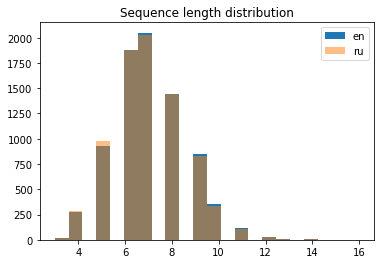

In [7]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=22, label='en');

plt.title('Sequence length distribution')
plt.hist(list(map(len, names_ru)),bins=22, alpha=0.5, label='ru');
plt.legend()

In [8]:
all_tokens_set_en = set()
for name in names:
    all_tokens_set_en.update(set(name))


tokens_en = list(all_tokens_set_en)# <list of all unique characters in the dataset>

num_tokens_en = len(tokens_en)
print ('num_tokens = ', num_tokens_en)

assert 50 < num_tokens_en < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


In [9]:
all_tokens_set_ru = set()
for name in names_ru:
    all_tokens_set_ru.update(set(name))


tokens_ru = list(all_tokens_set_ru)# <list of all unique characters in the dataset>

num_tokens_ru = len(tokens_ru)
print ('num_tokens = ', num_tokens_ru)

assert 50 < num_tokens_ru < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  54


In [10]:
token_to_id_en = {
    token: idx for idx, token in enumerate(tokens_en)
}

token_to_id_ru = {
    token: idx for idx, token in enumerate(tokens_ru)
}

In [11]:
assert len(tokens_ru) == len(token_to_id_ru), "dictionaries must have same size"

for i in range(num_tokens_ru):
    assert token_to_id_ru[tokens_ru[i]] == i, "token identifier must be it's position in tokens list"

for i in range(num_tokens_en):
    assert token_to_id_en[tokens_en[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [12]:
def to_matrix(names, token_to_id, max_len=None, pad=None, dtype='int32', batch_first=False):
    """Casts a list of names into rnn-digestable matrix"""
    pad = token_to_id[' ']
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [13]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [14]:
class MyModel(nn.Module):
    def __init__(self, num_tokens=num_tokens_en, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [15]:
model = MyModel()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [16]:
logp_seq = model(batch_ix)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens_en),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

In [17]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()

In [18]:
writer.add_graph(model, batch_ix)

In [19]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens_en),
                 batch_ix[:, 1:].contiguous().view(-1))

    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        writer.add_scalar('train loss', history[-1], i)

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

# Char-Level Machine Translation

    Task: Translate from English to Russian

In [20]:
class Encoder(nn.Module):
    def __init__(self, 
                 num_tokens=num_tokens_en, 
                 emb_size=16, 
                 rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_last = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_last

In [21]:
class Decoder(nn.Module):
    def __init__(self, 
                 num_tokens=num_tokens_ru, 
                 emb_size=16, 
                 rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, enc_last_state):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_last = self.rnn(self.emb(x), enc_last_state)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_last

In [34]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 num_tokens_en = num_tokens_en,
                 emb_size = 16,
                 rnn_num_units = 64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens_en, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens_en)
    
    def forward(self, src):
        h_seq, _ = self.rnn(self.emb(src))
        next_logit = self.hid_to_logits(h_seq)
        logp_seq = F.log_softmax(next_logit, dim = -1) 
        
        return logp_seq

In [35]:
model = Seq2Seq()
opt = torch.optim.SGD(model.parameters(), lr = 0.002)
loss_function = nn.NLLLoss()

In [36]:
indices = np.random.choice(np.arange(len(names)), size=32)
batch_en = to_matrix(np.array(names)[indices], token_to_id=token_to_id_en, max_len=MAX_LENGTH)
input_tensor = torch.from_numpy(batch_en).type(torch.int64)

batch_ru = to_matrix(np.array(names_ru)[indices], token_to_id=token_to_id_ru, max_len=MAX_LENGTH)
target_tensor = torch.from_numpy(batch_ru).type(torch.int64)

In [39]:
out = model(input_tensor)

In [40]:
idx_to_token_en = {idx: token for token, idx in token_to_id_en.items()}
idx_to_token_ru = {idx: token for token, idx in token_to_id_ru.items()}

In [41]:
a = out.argmax(dim=-1)

In [42]:
# ------------- Train model
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens_en),
                 batch_ix[:, 1:].contiguous().view(-1))

    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        writer.add_scalar('train loss', history[-1], i)

In [48]:
def get_example(idx):
    translated = ''.join([idx_to_token_ru[x] for x in a[:, idx].detach().numpy()])
    original = ''.join([idx_to_token_en[x] for x in input_tensor[:, idx].detach().numpy()])
    print(original, translated)

In [50]:
get_example(12)

 Darin            НфбНЗ          
